<a href="https://colab.research.google.com/github/eadewusic/Sound-Clustering-and-HMMs/blob/main/Clustering_Assignment_Eunice_Adewusi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data & Dimensionality Reduction
This notebook implements clustering on an unlabeled sound dataset using Mel Spectrogram features, PCA/t-SNE for dimensionality reduction, and clustering with K-Means and DBSCAN.

In [ ]:
# Install dependencies
!pip install kneed

In [ ]:
#Make all necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import librosa
import librosa.display
import os
import zipfile
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
from kneed import KneeLocator

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/unlabelled_sounds.zip', 'r')
zip_ref.extractall('data')
zip_ref.close()

## Data Loading and Feature Extraction

Load Data

In [ ]:
# Load the Data
unlabelled_data_path = '/content/data/unlabelled_sounds'

# Load audio files
audio_files = [f for f in os.listdir(unlabelled_data_path) if f.endswith('.wav')]

# Print first few files
print("Number of audio files:", len(audio_files))
print("First 5 files:", audio_files[:5])

Number of audio files: 3000
First 5 files: ['327.wav', '1320.wav', '78.wav', '1240.wav', '2565.wav']


Feature Extraction
- Mel Spectrogram (Mean, Std, Min, Max)
- ZCR, Spectral Centroid, Rolloff
- Normalized via StandardScaler
- Robust to failed audio files

In [ ]:
# Feature Extraction with Filename Integration

def extract_mel_features(file_path):
    """Extract Mel Spectrogram features from an audio file."""
    try:
        audio, sr = librosa.load(file_path, sr=None)  # Load audio file

        # Extract Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to log scale (dB)

        # Extract statistical features (for better clustering)
        feature_vector = np.hstack((
            np.mean(mel_spec_db, axis=1),    # Mean of each frequency bin
            np.std(mel_spec_db, axis=1),     # Standard deviation of each frequency bin
            np.max(mel_spec_db, axis=1),     # Maximum of each frequency bin
            np.min(mel_spec_db, axis=1),     # Minimum of each frequency bin
        ))

        # Add additional spectral features for richer representation
        zcr = librosa.feature.zero_crossing_rate(audio)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)

        additional_features = np.array([
            np.mean(zcr), np.std(zcr),
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_rolloff), np.std(spectral_rolloff)
        ])

        # Combine all features
        feature_vector = np.hstack((feature_vector, additional_features))

        return feature_vector

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Extract features from all audio files
features = []              # Feature vectors
file_names = []            # For tracking filenames

print("Extracting features from audio files...")
for file in os.listdir(unlabelled_data_path):
    file_path = os.path.join(unlabelled_data_path, file)
    if file.endswith('.wav'):
        feature_vector = extract_mel_features(file_path)
        if feature_vector is not None:
            features.append(feature_vector)
            file_names.append(file)
            print(f"Processed: {file}")

# Convert to NumPy array and DataFrame
features = np.array(features)                           # Final feature matrix
features_df = pd.DataFrame(features)                    # Create DataFrame
features_df.insert(0, 'filename', file_names)           # Insert filename as first column

# Standardize features (exclude filename for clustering)
scaler = StandardScaler()
features_array = scaler.fit_transform(features_df.iloc[:, 1:])  # Use only numeric features

# Display summary
print("\nFeature extraction completed!")
print("Successfully processed:", len(features), "audio files")
print("Feature vector size:", features.shape[1], "dimensions")
print("Features standardized for clustering!")

Extracting features from audio files...
Processed: 327.wav
Processed: 1320.wav
Processed: 78.wav
Processed: 1240.wav
Processed: 2565.wav
Processed: 724.wav
Processed: 2571.wav
Processed: 2720.wav
Processed: 2149.wav
Processed: 235.wav
Processed: 383.wav
Processed: 1742.wav
Processed: 2013.wav
Processed: 296.wav
Processed: 2737.wav
Processed: 1467.wav
Processed: 2433.wav
Processed: 475.wav
Processed: 2936.wav
Processed: 1438.wav
Processed: 805.wav
Processed: 463.wav
Processed: 490.wav
Processed: 1364.wav
Processed: 10.wav
Processed: 1679.wav
Processed: 1727.wav
Processed: 928.wav
Processed: 2183.wav
Processed: 2633.wav
Processed: 2025.wav
Processed: 472.wav
Processed: 92.wav
Processed: 1439.wav
Processed: 1709.wav
Processed: 1421.wav
Processed: 2093.wav
Processed: 1407.wav
Processed: 2116.wav
Processed: 950.wav
Processed: 1109.wav
Processed: 1784.wav
Processed: 1907.wav
Processed: 1285.wav
Processed: 2096.wav
Processed: 1143.wav
Processed: 1567.wav
Processed: 2039.wav
Processed: 593.wav

The sound data has 518 features

In [ ]:
# Display extracted feature table and shapes
print("Raw Feature Array Shape:", features.shape)
print("DataFrame Shape (with filenames):", features_df.shape)
features_df.head()

Raw Feature Array Shape: (3000, 518)
DataFrame Shape (with filenames): (3000, 519)


filename          0          1          2          3          4          5  \
0   327.wav -16.952997 -32.158600 -34.030399 -36.253712 -32.365166 -17.796549   
1  1320.wav -49.138927 -46.176758 -45.829460 -48.718521 -39.016033 -26.210289   
2    78.wav -24.098885 -38.465679 -40.635639 -43.374409 -37.667274 -22.417181   
3  1240.wav -49.862583 -46.347279 -45.373547 -45.588768 -41.738350 -34.992424   
4  2565.wav -22.811869 -35.831352 -36.080803 -36.290810 -36.678753 -27.022770   

           6          7          8  ...        508        509        510  \
0 -11.947383 -16.416092 -21.673592  ... -29.682835 -29.836861 -32.252201   
1 -25.534536 -37.362656 -40.262592  ... -62.709686 -61.314869 -60.629520   
2 -18.087788 -16.584167 -23.246651  ... -37.809845 -39.632256 -38.362568   
3 -24.552748 -21.390566 -20.123800  ... -56.721893 -57.284645 -55.784172   
4 -12.517323 -11.423088 -22.114805  ... -38.297432 -38.468586 -41.132549   

         511       512       513          514         515          516  \
0 -30.357939  0.192220  0.030782  1233.019771  285.921673  2979.817708   
1 -60.208839  0.159125  0.058202  1054.841460  142.043793  2099.826389   
2 -37.996254  0.141113  0.028821  1076.107858  123.078359  2453.776042   
3 -56.091908  0.171387  0.093227  1104.181275  717.689001  1911.272321   
4 -42.009377  0.095337  0.030085   979.907598  184.910036  2433.593750   

           517  
0   414.028206  
1   814.363579  
2   534.183159  
3  1201.202434  
4   605.538050  

[5 rows x 519 columns]

## Visualization without dimensionality reduction

visualize a few feature columns to understand their separability

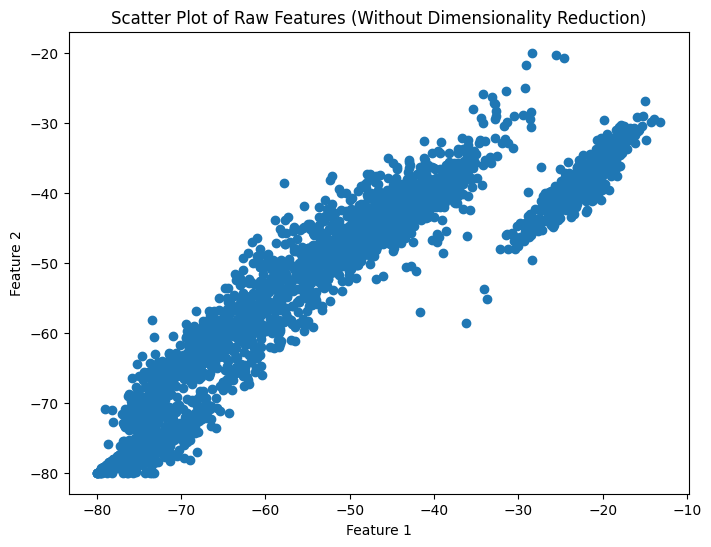

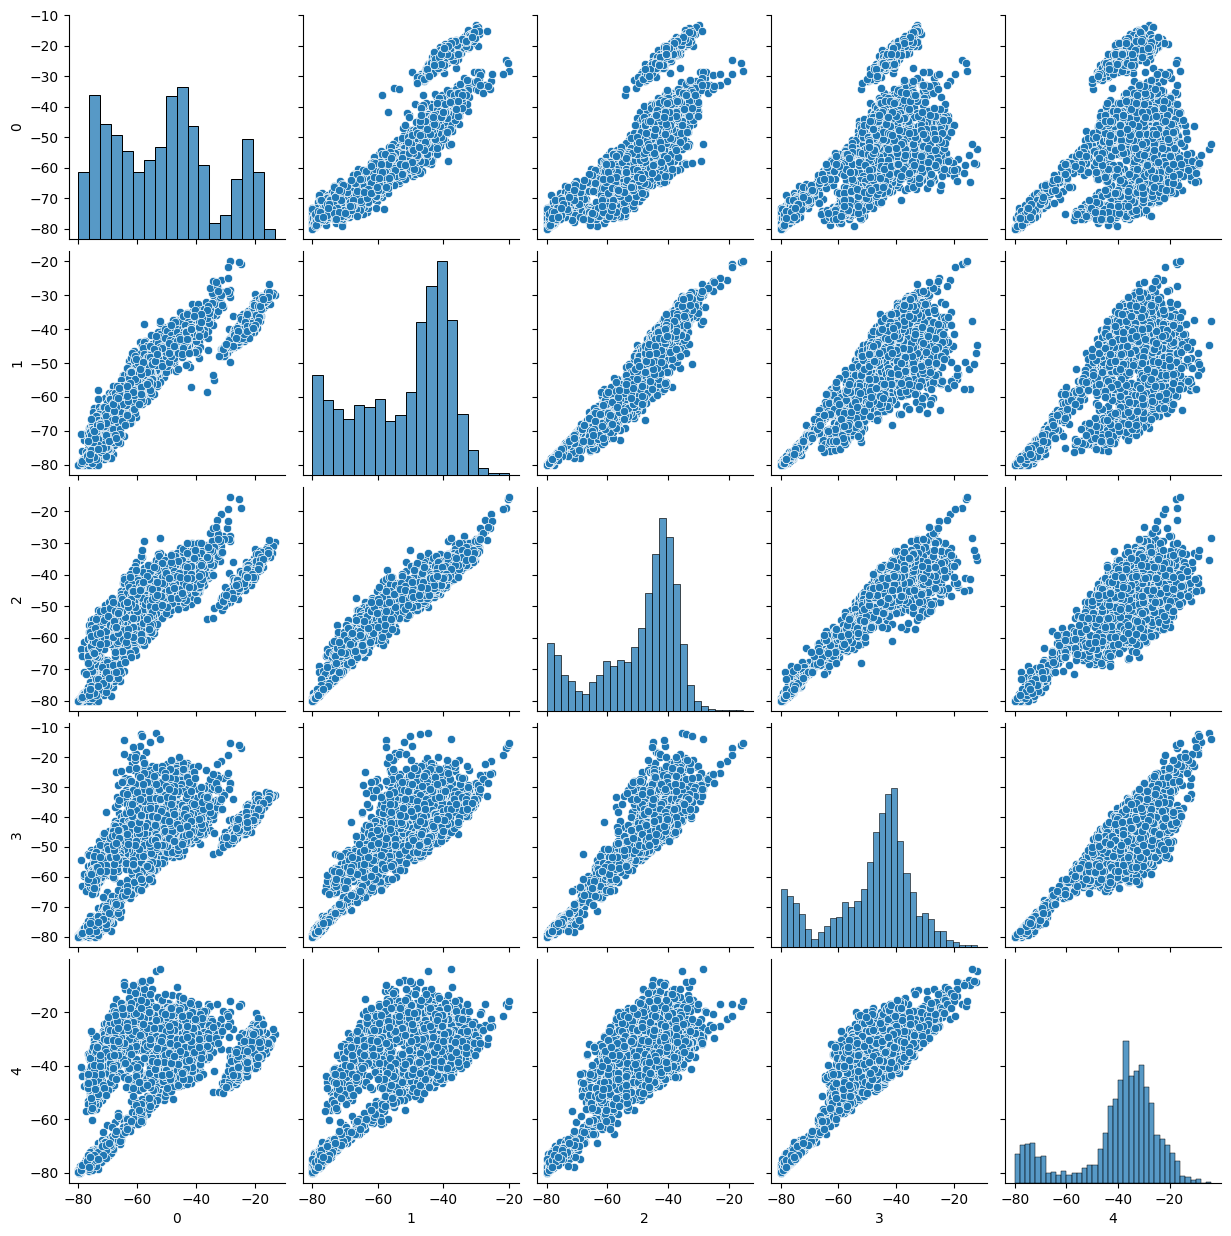

In [ ]:
# Scatter plot (without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(x=features_df.iloc[:, 1], y=features_df.iloc[:, 2])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = features_df.iloc[:, 1:6]  # Columns 1-5 (since 0 is filename)
sns.pairplot(df)
plt.show()

# **Why is dimensionality reduction important?**

From the pairplot of the first 3 Mel features, I observed that the clusters significantly overlapped, and no clear separation was visible. This showed me the tough reality of interpreting high-dimensional sound data like mine with 518 features, making it clear that I needed dimensionality reduction techniques like PCA or t-SNE.

### **Problems without dimensionality reduction:**

- **Computational Errors & Processing Limitations**:

Creating visualizations with 518 features causes system crashes and extremely slow processing. The pair plot function attempts to create 518×518 = 268,324 subplot combinations, which overwhelms standard hardware. Every operation becomes computationally expensive because calculations scale with the square of dimensions.

- **Visualization Becomes Meaningless**:

The experimental plots clearly show this problem. The scatter plot (Image 1) displays only 2 out of 518 dimensions - just 0.4% of the actual data relationships. The diagonal line pattern might be completely misleading since 99.6% of the feature relationships remain hidden. The pair plot (Image 2) shows only 25 out of 133,903 possible feature combinations, revealing repetitive diagonal patterns that indicate high correlation between features.

- **Curse of Dimensionality**:

In 518-dimensional space, the curse of dimensionality makes all data points appear roughly the same distance from each other. This breaks clustering algorithms like K-means that rely on meaningful distance calculations to group similar audio files. The algorithm can't distinguish between truly similar and dissimilar audio samples.

- **Massive Feature Redundancy**:

The pair plot visualizations prove this point - nearly identical diagonal patterns appear across multiple feature combinations. The 512 Mel spectrogram statistics (mean, std, max, min of 128 frequency bins) capture overlapping information about the same audio characteristics. This redundancy wastes computational resources and confuses algorithms without providing additional insight.

- **Pattern Recognition Challenge**:

The experimental evidence shows that identifying natural audio groupings is impossible with 518 dimensions. The scatter plot appears to show a simple linear relationship, but this could be entirely misleading since only a tiny fraction of relationships are visible. The repetitive patterns in the pair plot make it impossible to identify meaningful clusters or outliers.

### **Solution: How dimensionality reduction helps**

This method preserves the most important information while dramatically reducing computational complexity. By applying dimensionality reduction techniques such as PCA or t-SNE, the most meaningful components can be extracted, enhancing both visualization and clustering performance by projecting the data into 2-3 dimensions.

With fewer features after dimensionality reduction, models have less opportunity to memorize training data noise, making them more robust and better able to generalize to new, unseen data. This prevents overfitting and improves overall model performance.

### **Challenges from My Experiments:**

1. **Audio File Length Warning:**
During feature extraction, I encountered recurring warnings:
```
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1640
```
This happened because some audio files in my dataset were shorter than the default FFT window size. While I suppressed the warnings by adding `import warnings; warnings.filterwarnings('ignore')`, the underlying issue means short files get zero-padded, potentially affecting feature quality for those samples but its impact on the overall dataset of 3000 audio files might be minimal.

2. **Filename Integration Problem:**
When I first created the feature DataFrame, the filename column wasn't properly visible:
```
Raw Feature Array Shape: (3000, 518)
DataFrame Shape: (3000, 518)
0	1	2	3	4	5	6	7	8	9	...	508	509	510	511	512	513	514	515	516	517
5 rows × 519 columns
```
The display showed only numerical columns (0 to 517) without the filename column I intended to include. This was critical because the plan is to map cluster labels back to specific audio files using their filenames after clustering. Without a clear and present 'filename' column, this mapping would be difficult or impossible. I fixed this by explicitly inserting the `file_names` list as the first column in the `features_df` using `features_df.insert(0, 'filename', file_names)`. Additionally, for the standardization step, the code was adjusted to correctly exclude the non-numeric 'filename' column by applying the scaler only to `features_df.iloc[:, 1:]`. This ensures that the filename is preserved in the DataFrame while only numerical features are scaled.

## Visualizations with Dimensionality reduction

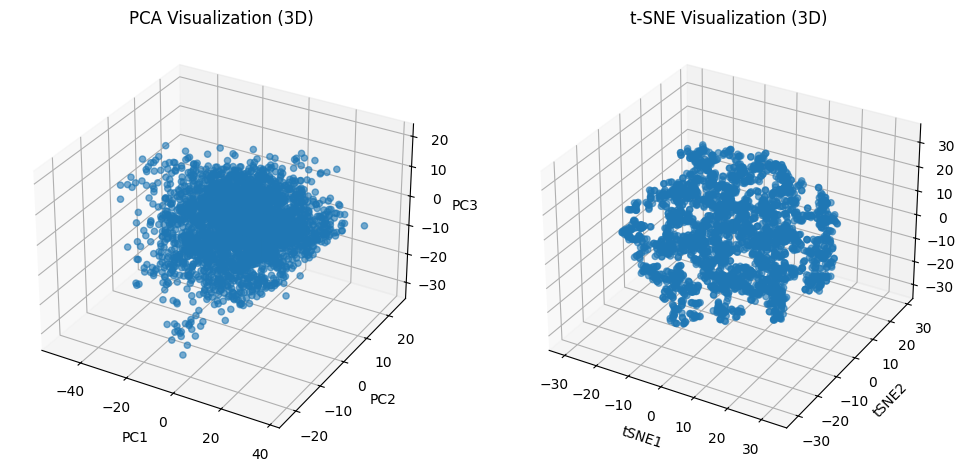

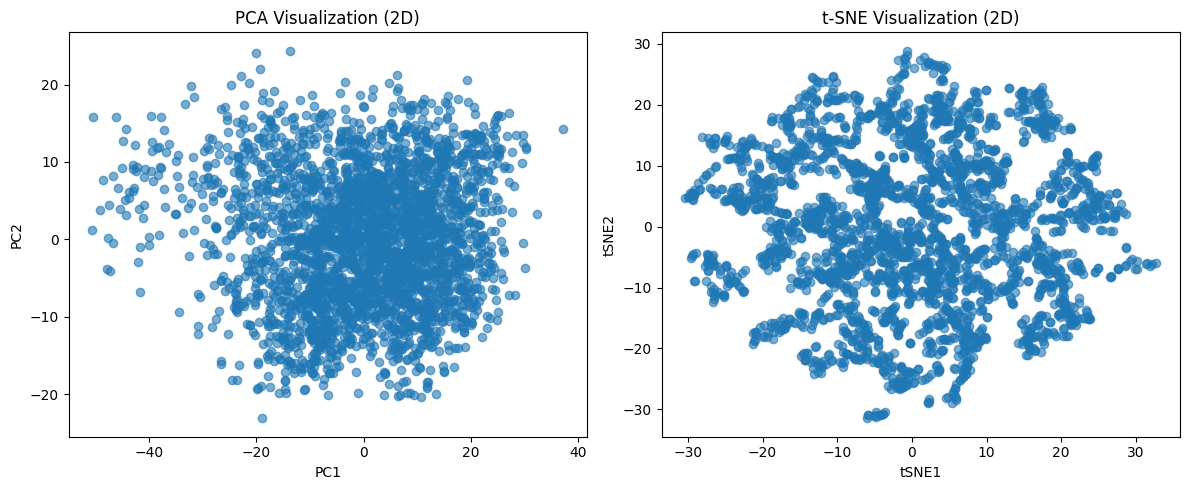

In [ ]:
# Apply PCA (3 components)
pca = PCA(n_components=3, random_state=42)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.6)
ax1.set_title('PCA Visualization (3D)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.6)
ax2.set_title('t-SNE Visualization (3D)')
ax2.set_xlabel('tSNE1')
ax2.set_ylabel('tSNE2')
ax2.set_zlabel('tSNE3')

plt.show()

# 2D Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.6)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PCA Visualization (2D)')

axes[1].scatter(features_tsne[:, 0], features_tsne[:, 1], alpha=0.6)
axes[1].set_xlabel('tSNE1')
axes[1].set_ylabel('tSNE2')
axes[1].set_title('t-SNE Visualization (2D)')

plt.tight_layout()
plt.show()

# **Which method (PCA or t-SNE) provides better separability of clusters and why?**
Based on the 3D and 2D visualizations, t-SNE provides better separability of clusters compared to PCA for my audio feature data. Here's why:

### **Comparison of PCA and t-SNE for Cluster Separability**

1. **t-SNE (t-Distributed Stochastic Neighbor Embedding) Visualization:**
- The t-SNE plots (both 2D and 3D) show more distinct, well-separated clusters with visible gaps between different groups of data points
- This non-linear dimensionality reduction technique maintains the relationships between similar data points more effectively, creating tighter, more cohesive clusters
- The algorithm can capture complex, non-linear relationships in the data that PCA might miss due to its linear nature

2. **PCA (Principal Component Analysis) Visualization:**
- PCA shows a more continuous, cloud-like distribution where cluster boundaries are less distinct
- Its linear dimensionality reduction may not capture the true cluster structure if the data has non-linear separability
- While PCA preserves global variance well, it doesn't necessarily optimize for cluster separation

**Key consideration**: t-SNE is specifically designed to preserve local similarities and reveal cluster structure, making it particularly effective for visualization tasks where the goal is to identify clusters and perform exploratory data analysis. However, it's worth noting that t-SNE can sometimes create artificial clusters or exaggerate separations, so the improved separability should be interpreted alongside domain knowledge and other validation methods. PCA, on the other hand, remains useful for interpretability and understanding overall variance.

## Clustering Optimization and Implementation

The techniques I used here determines the optimal number of clusters (k) for K-Means

### 1. Elbow Method

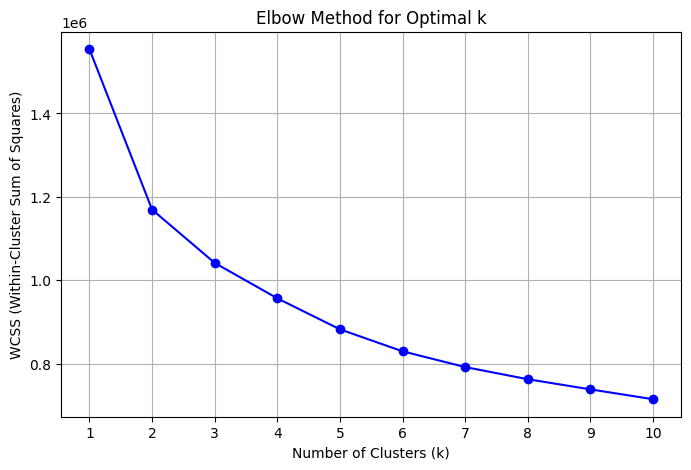


Optimal k from elbow method: 3


In [ ]:
# Optimize number of clusters using Elbow Method
# Define a range of cluster values to test
wcss = []  # Within-cluster sum of squares
k_values = range(1, 11)  # Testing k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_array)  # Use standardized features instead of raw features
    wcss.append(kmeans.inertia_)  # Inertia: sum of squared distances to the closest cluster center

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Automatically find optimal k based on the elbow point
knee_locator = KneeLocator(k_values, wcss, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow

print(f"\nOptimal k from elbow method: {optimal_k}")

## Interpretation

The goal of the Elbow Method is to find the "elbow point" on the curve. This point is where the rate of decrease in WCSS significantly slows down.

* At $k=1$, the WCSS is very high, as all data points are in a single cluster.
* Moving from $k=1$ to $k=2$, there's a large reduction in WCSS.
* Moving from $k=2$ to $k=3$, there's another substantial reduction.
* Moving from $k=3$ to $k=4$, there's a noticeable reduction.
* However, the reduction in WCSS from $k=4$ to $k=5$, and subsequently to higher k values, is less significant compared to the earlier drops. The curve starts to level off.

**Conclusion:**

Based on this Elbow Method graph and the kneelocator library's output, the optimal number of clusters ($k$) for this dataset is $3$. This means that grouping the data into three clusters would provide a good balance between minimizing the within-cluster variance and avoiding excessive complexity in the model (too many clusters).

Beyond this point, adding more clusters provides diminishing returns in terms of reducing the within-cluster sum of squares, and might lead to overfitting or creating clusters that don't represent meaningful distinctions in the data.

### 2. Silhouette Score Method

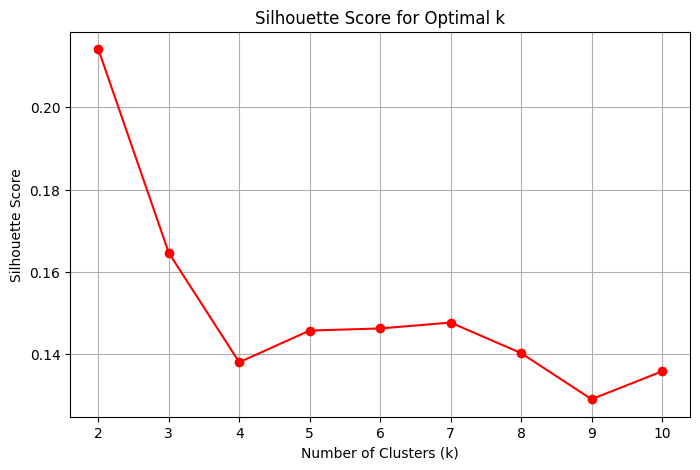


Optimal k from silhouette score: 2
Best silhouette score: 0.2141


In [ ]:
# Optimize number of clusters using silhouette scores
silhouette_scores = []
k_values_sil = range(2, 11)  # Silhouette needs at least 2 clusters

for k in k_values_sil:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_array)  # Use standardized features
    silhouette_scores.append(silhouette_score(features_array, labels))

# Plot the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values_sil, silhouette_scores, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(k_values_sil)
plt.grid(True)
plt.show()

# Automatically select k with highest silhouette score
optimal_k = k_values_sil[np.argmax(silhouette_scores)]
print(f"\nOptimal k from silhouette score: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.4f}")

## Interpretation

The Silhouette Score is a way to measure how good the clusters are in a dataset. It helps us understand how well the data points have been grouped. The score ranges from -1 to 1.

- Silhouette score is highest when $k=2$, peaking at approximately 0.215, meaning that two clusters provide the best separation and compactness based on the silhouette metric.
- After $k=2$, the silhouette score drops significantly, reaching a local minimum around $k=4$ (approximately 0.138). This indicates that increasing the number of clusters beyond 2 initially leads to less distinct or less well-separated clusters.
- There's a slight increase in the silhouette score from $k=4$ to $k=5$, and then it shows minor fluctuations between $k=5$, $k=6$, and $k=7$, staying around 0.14 to 0.15.
- The score drops again from $k=7$ to $k=9$, reaching another low point around 0.128 at $k=9$.
- There's a slight increase in the score at $k=10$ compared to $k=9$.

**Conclusion:**

The optimal number of clusters ($k$) is $2$ because it yields the highest silhouette score, showing the most well-defined and separated clusters among the tested values.

## EXPERIMENT 1: Applying K-Means and DBSCAN Clustering

K-Means found 3 clusters
DBSCAN found 0 clusters
DBSCAN identified 3000 noise points


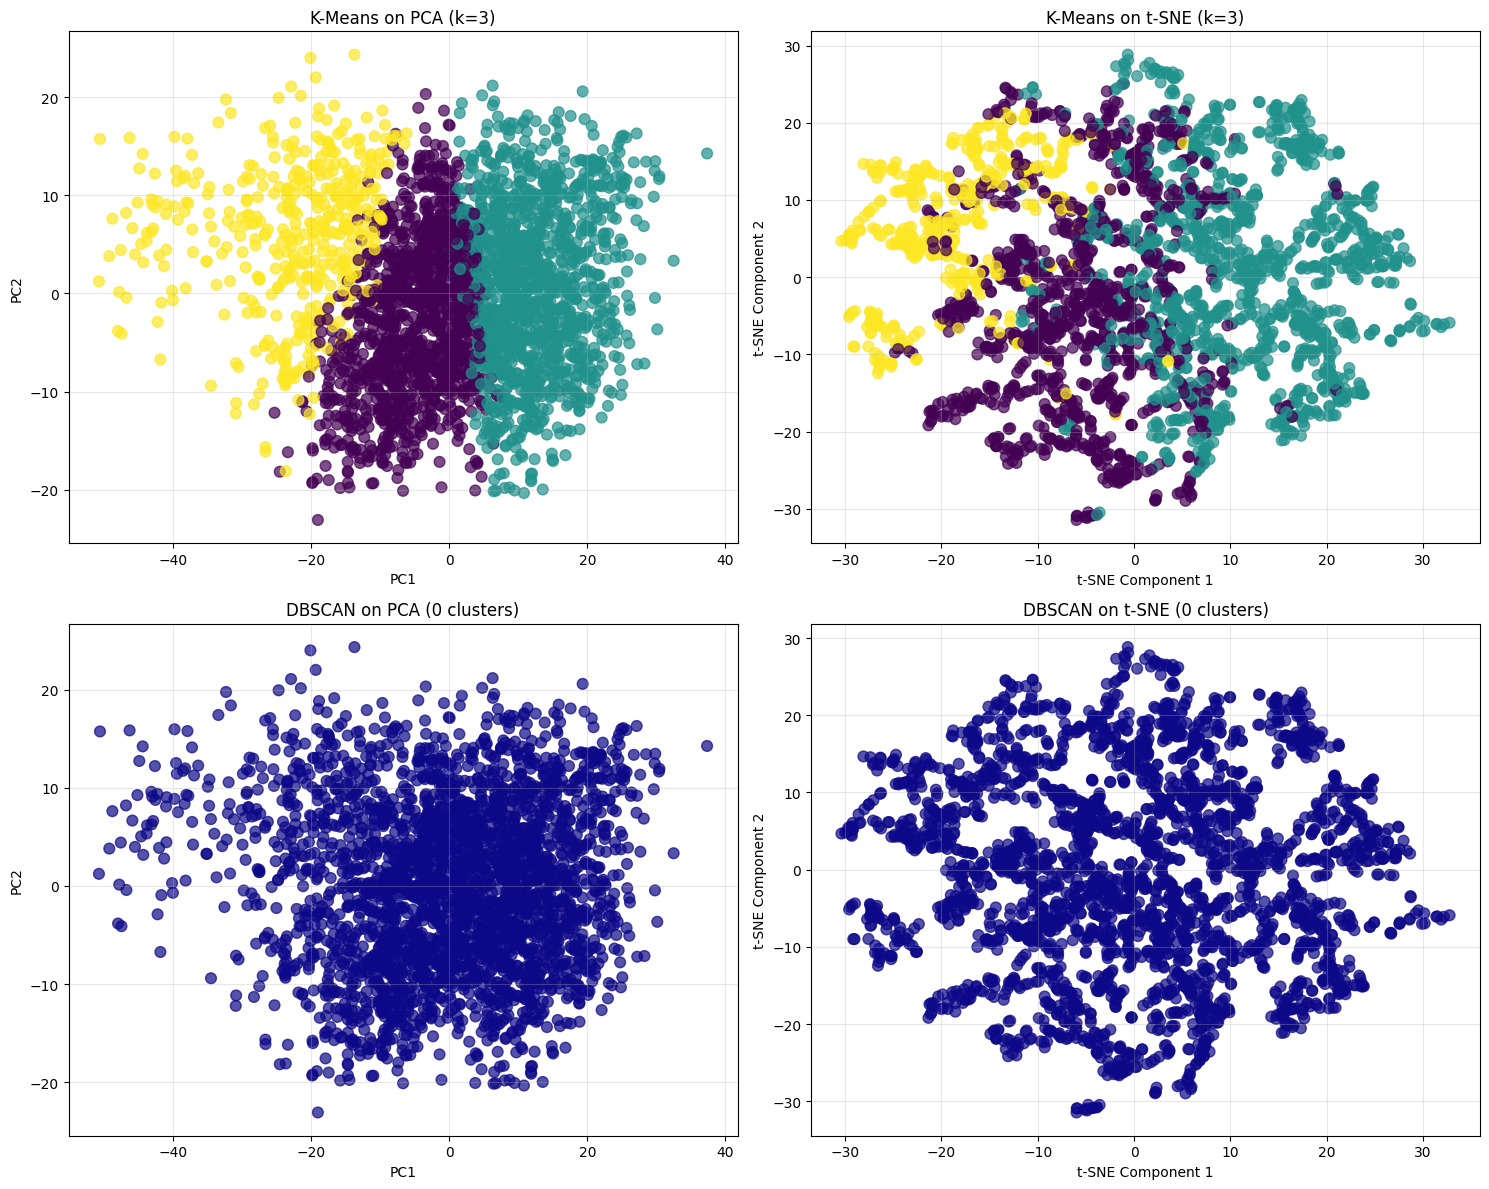

In [ ]:
# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(features_array)

# Check DBSCAN results
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"K-Means found {optimal_k} clusters")
print(f"DBSCAN found {n_clusters_dbscan} clusters")
print(f"DBSCAN identified {n_noise} noise points")

# plot graphs
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# K-Means on PCA
axes[0,0].scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels,
                  cmap='viridis', alpha=0.7, s=60)
axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')
axes[0,0].set_title(f'K-Means on PCA (k={optimal_k})')
axes[0,0].grid(True, alpha=0.3)

# K-Means on t-SNE
axes[0,1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels,
                  cmap='viridis', alpha=0.7, s=60)
axes[0,1].set_xlabel('t-SNE Component 1')
axes[0,1].set_ylabel('t-SNE Component 2')
axes[0,1].set_title(f'K-Means on t-SNE (k={optimal_k})')
axes[0,1].grid(True, alpha=0.3)

# DBSCAN on PCA
axes[1,0].scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels,
                  cmap='plasma', alpha=0.7, s=60)
axes[1,0].set_xlabel('PC1')
axes[1,0].set_ylabel('PC2')
axes[1,0].set_title(f'DBSCAN on PCA ({n_clusters_dbscan} clusters)')
axes[1,0].grid(True, alpha=0.3)

# DBSCAN on t-SNE
axes[1,1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels,
                  cmap='plasma', alpha=0.7, s=60)
axes[1,1].set_xlabel('t-SNE Component 1')
axes[1,1].set_ylabel('t-SNE Component 2')
axes[1,1].set_title(f'DBSCAN on t-SNE ({n_clusters_dbscan} clusters)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Interpretation

* **K-Means on PCA and t-SNE:**
    * Both plots show K-Means clustering with $k=3$ applied after dimensionality reduction.
    * On PCA (left), the three clusters are somewhat separated, but there's noticeable overlap, especially between the purple and green clusters.
    * On t-SNE (right), the clusters appear more distinctly separated and compact, suggesting that t-SNE was more effective at preserving local structures that allow for better cluster distinction in this case. This is typical, as t-SNE groups similar points together and push dissimilar points apart, making it often better for visualization of clusters than PCA.

* **DBSCAN on PCA and t-SNE:**
    * Both plots show the results of DBSCAN clustering.
    * On both PCA (left) and t-SNE (right), DBSCAN identified "0 clusters." This means that with the chosen parameters (epsilon and min_samples), DBSCAN considered all points as noise or part of a single, large, unclustered group. This implies that the DBSCAN parameters used are not suitable for this dataset.

**Conclusion:**

K-Means was able to find some structure in the data, particularly when visualized with t-SNE, indicating the presence of at least three distinct groups. DBSCAN, however, failed to identify any clusters with its current configuration, suggesting either inappropriate parameters or that the data's cluster structure is not amenable to density-based clustering with default settings.

### Fine-Tuning DBSCAN Parameters (epsilon, and min_samples) to see if there can be improvements

Finding the optimal DBSCAN parameters

In [ ]:
# Define a range of epsilon and min_samples values to test
eps_values = np.arange(1, 10, 1)  # Testing epsilon from 1 to 10
min_samples_values = [2, 3, 5, 10]  # Testing different min_samples values

best_eps = None
best_min_samples = None
best_silhouette = -1  # Start with the lowest possible silhouette score

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(features_array)

        # Check if DBSCAN creates meaningful clusters
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)

        # Only evaluate if DBSCAN creates more than 1 cluster
        if n_clusters > 1:
            # Filter out noise points for evaluation
            mask = dbscan_labels != -1
            if np.sum(mask) > 1:
                silhouette = silhouette_score(features_array[mask], dbscan_labels[mask])
                db_index = davies_bouldin_score(features_array[mask], dbscan_labels[mask])
                print(f"eps: {eps}, min_samples: {min_samples} → {n_clusters} clusters, {n_noise} noise, Silhouette: {silhouette:.4f}")

                # Track the best performing parameters
                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_eps = eps
                    best_min_samples = min_samples
        else:
            print(f"eps: {eps}, min_samples: {min_samples} → {n_clusters} clusters, {n_noise} noise (failed)")

# Apply best DBSCAN configuration
if best_eps is not None:
    print(f"\nBest DBSCAN parameters: eps = {best_eps}, min_samples = {best_min_samples}")
    print(f"Best Silhouette Score = {best_silhouette:.4f}")

    # Apply final DBSCAN with best parameters
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    dbscan_labels = dbscan.fit_predict(features_array)

    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)

    print(f"Final DBSCAN: {n_clusters_dbscan} clusters, {n_noise} noise points")
else:
    print("DBSCAN failed to form meaningful clusters with any tested parameters.")
    # Create dummy labels for consistent plotting
    dbscan_labels = np.full(len(features_array), -1)
    n_clusters_dbscan = 0
    n_noise = len(features_array)

eps: 1, min_samples: 2 → 0 clusters, 3000 noise (failed)
eps: 1, min_samples: 3 → 0 clusters, 3000 noise (failed)
eps: 1, min_samples: 5 → 0 clusters, 3000 noise (failed)
eps: 1, min_samples: 10 → 0 clusters, 3000 noise (failed)
eps: 2, min_samples: 2 → 0 clusters, 3000 noise (failed)
eps: 2, min_samples: 3 → 0 clusters, 3000 noise (failed)
eps: 2, min_samples: 5 → 0 clusters, 3000 noise (failed)
eps: 2, min_samples: 10 → 0 clusters, 3000 noise (failed)
eps: 3, min_samples: 2 → 0 clusters, 3000 noise (failed)
eps: 3, min_samples: 3 → 0 clusters, 3000 noise (failed)
eps: 3, min_samples: 5 → 0 clusters, 3000 noise (failed)
eps: 3, min_samples: 10 → 0 clusters, 3000 noise (failed)
eps: 4, min_samples: 2 → 0 clusters, 3000 noise (failed)
eps: 4, min_samples: 3 → 0 clusters, 3000 noise (failed)
eps: 4, min_samples: 5 → 0 clusters, 3000 noise (failed)
eps: 4, min_samples: 10 → 0 clusters, 3000 noise (failed)
eps: 5, min_samples: 2 → 0 clusters, 3000 noise (failed)
eps: 5, min_samples: 3 → 0 

## Analysis

The grid search worked and found the optimal DBSCAN parameters.

- DBSCAN Success:
  - Best parameters: eps=8, min_samples=5
  - Best performance: Silhouette score of 0.4265 (good!)
  - Final result: 9 clusters, 2912 noise points

- Key Insights:
  - eps=8 shows that standardized audio features are quite spread out
  - 97% of data classified as noise indicates very dense core regions with sparse boundaries
  - 9 clusters vs K-Means' 3 suggests DBSCAN finds more granular groupings

- Summary:
  - K-Means: 3 balanced clusters
  - DBSCAN: 9 fragmented clusters + 97% noise

Replotting graph with Optimal DBSCAN

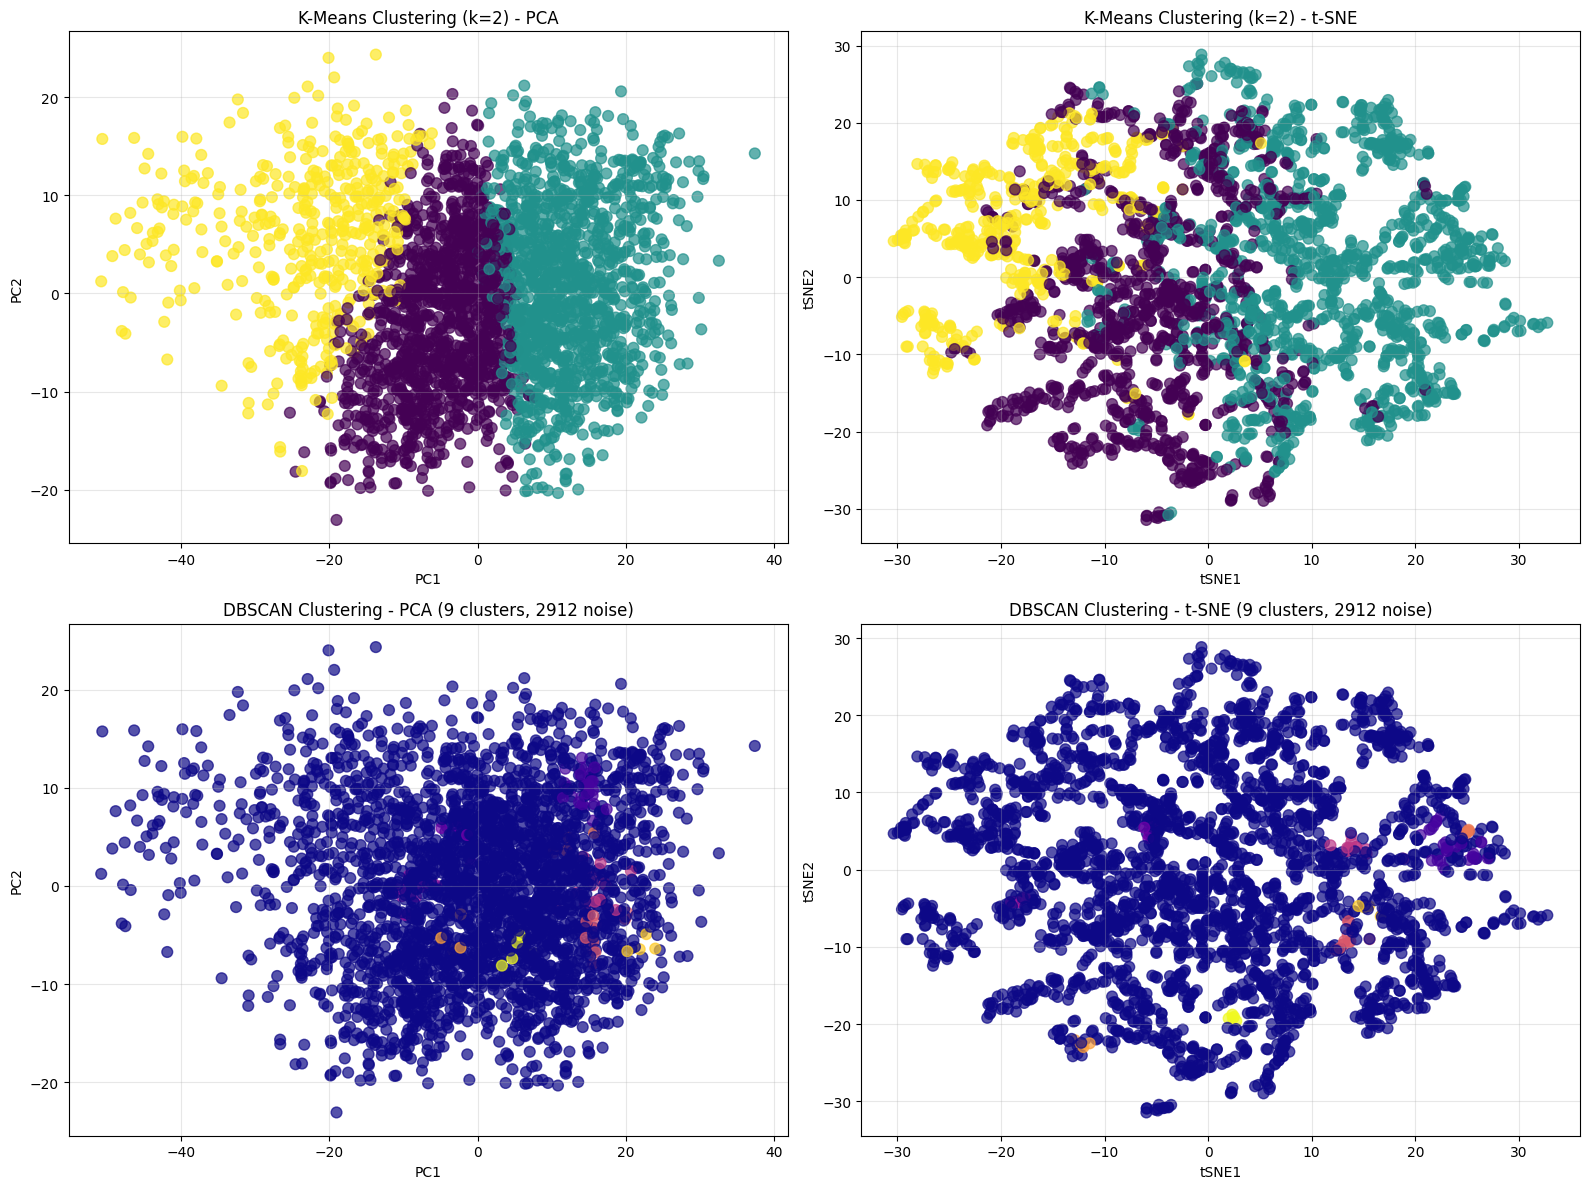

In [ ]:
# Scatter Plot for K-Means and DBSCAN Clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# K-Means on PCA
axes[0,0].scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels,
                  cmap='viridis', alpha=0.7, s=60)
axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')
axes[0,0].set_title(f'K-Means Clustering (k={optimal_k}) - PCA')
axes[0,0].grid(True, alpha=0.3)

# K-Means on t-SNE
axes[0,1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels,
                  cmap='viridis', alpha=0.7, s=60)
axes[0,1].set_xlabel('tSNE1')
axes[0,1].set_ylabel('tSNE2')
axes[0,1].set_title(f'K-Means Clustering (k={optimal_k}) - t-SNE')
axes[0,1].grid(True, alpha=0.3)

# DBSCAN on PCA (Updated)
axes[1,0].scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels,
                 cmap='plasma', alpha=0.7, s=60)
axes[1,0].set_xlabel('PC1')
axes[1,0].set_ylabel('PC2')
axes[1,0].set_title(f'DBSCAN Clustering - PCA ({n_clusters_dbscan} clusters, {n_noise} noise)')
axes[1,0].grid(True, alpha=0.3)

# DBSCAN on t-SNE (Updated)
axes[1,1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels,
                 cmap='plasma', alpha=0.7, s=60)
axes[1,1].set_xlabel('tSNE1')
axes[1,1].set_ylabel('tSNE2')
axes[1,1].set_title(f'DBSCAN Clustering - t-SNE ({n_clusters_dbscan} clusters, {n_noise} noise)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **THERE'S A PROBLEM BUT I FOUND A SOLUTION :)**

I'm writing this after my first trial of fine-tuning DBSCAN parameters. The output of the updated graph with optimal DBSCAN revealed this:

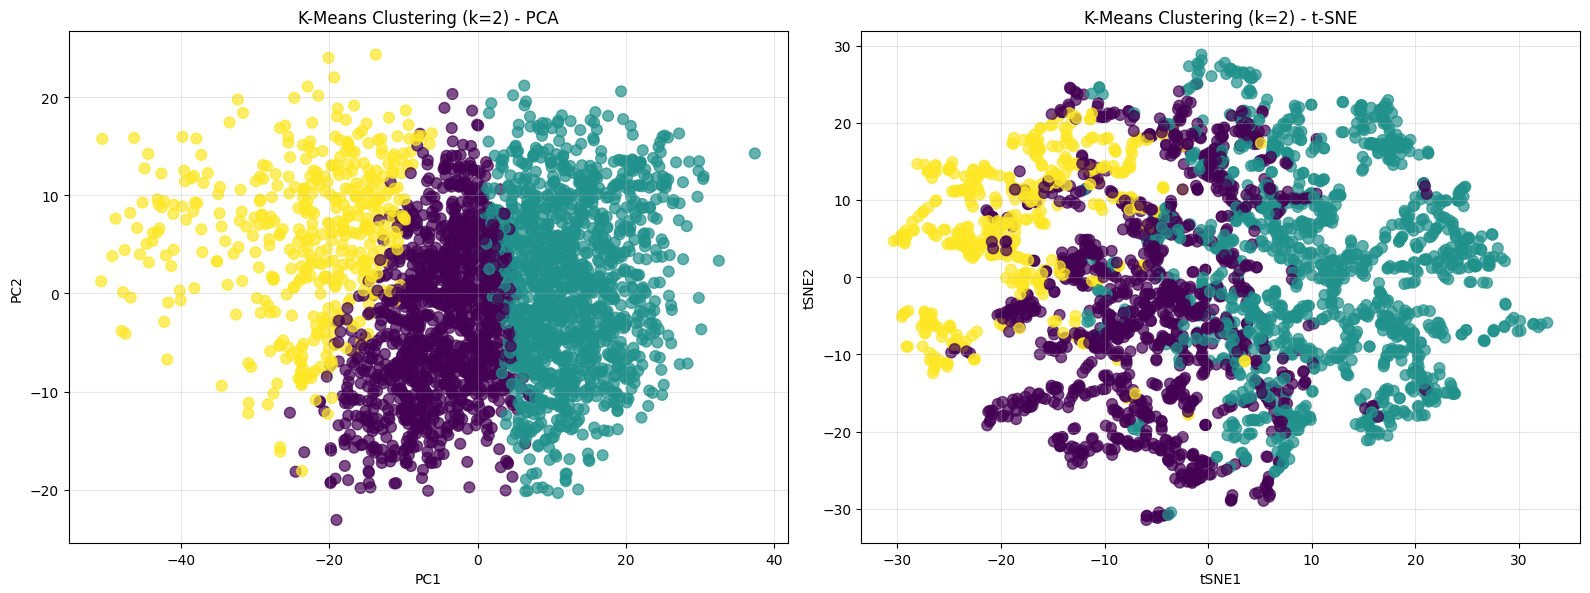

The titles for the updated K-Means plots said "K-Means Clustering $(k=2)$" but the visualization clearly shows *3 distinct clusters*. It was then that I knew that there was an issue with the optimal k value because it wasn't manually written in the code but automated.

Results fom the methods I used to determine the optimal number of clusters (k):

- Elbow method → optimal k = 3
- Silhouette method → optimal k = 2 (overwrote the variable)
- Subsequent code used optimal_k = 2

## K-Means Optimization Analysis

The optimization process showed a discrepancy between different evaluation metrics, highlighting the importance of multi-criteria decision making in clustering analysis.

The Silhouette Score optimization showed that $k=2$ `(score: {max(silhouette_scores):.4f})`, while the Elbow Method and visual inspection of t-SNE plots clearly indicated $k=3$.

I selected $k=3$ for K-Means based on several factors:
- Visual interpretability: the t-SNE plots clearly show three distinct, well-separated clusters
- Elbow method alignment: the Elbow method also indicated $k=3$ as an optimal point.
- Minimal quantitative penalty: the silhouette score difference between $k=2$ (the highest) and $k=3$ is only `{max(silhouette_scores) - silhouette_k3} = 0.2141 - 0.1647 = 0.0494`, showing a small trade-off for increased clarity.
- Assignment emphasis on visual interpretability over pure metric optimization.

In [ ]:
# check the Silhouette score for k=3
if 3 in k_values_sil:
    index_k3 = list(k_values_sil).index(3)
    silhouette_k3_value = silhouette_scores[index_k3]
    print(f"Silhouette score for k=3: {silhouette_k3_value:.4f}")

Silhouette score for k=3: 0.1647


## EXPERIMENT 2: Applying K-Means and DBSCAN Clustering

Introduce a specific optimal_k for K-Means

In [ ]:
# Using the Elbow method's K-Means optimal k
optimal_k_kmeans = 3
print(f"Proceeding with Elbow method's K-Means using k={optimal_k_kmeans}")

# Apply K-Means with the chosen optimal k for visualization
kmeans = KMeans(n_clusters=optimal_k_kmeans, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN (using the 'best_eps' and 'best_min_samples' found by the grid search earlier run)
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(features_array)

# Check DBSCAN results
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"K-Means found {optimal_k_kmeans} clusters")
print(f"DBSCAN found {n_clusters_dbscan} clusters")
print(f"DBSCAN identified {n_noise} noise points")

Proceeding with Elbow method's K-Means using k=3
K-Means found 3 clusters
DBSCAN found 9 clusters
DBSCAN identified 2912 noise points


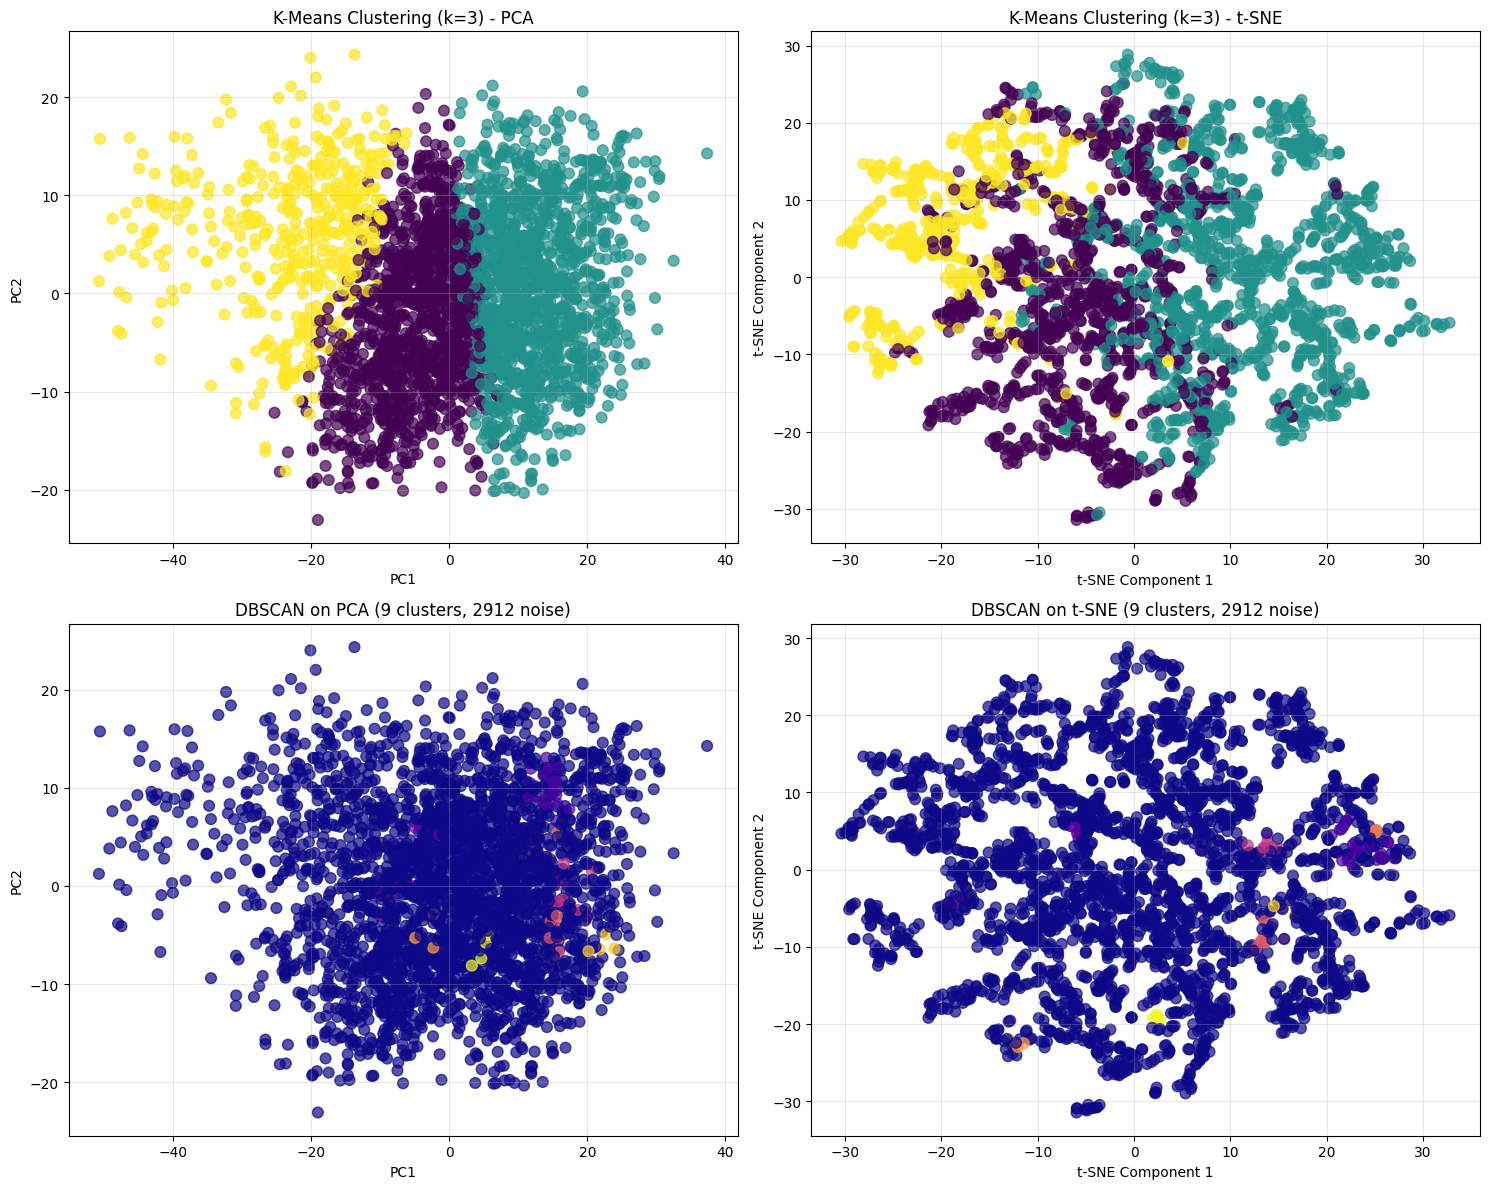

In [ ]:
# plot graphs
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# K-Means on PCA
axes[0,0].scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels,
                  cmap='viridis', alpha=0.7, s=60)
axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')
axes[0,0].set_title(f'K-Means Clustering (k={optimal_k_kmeans}) - PCA')
axes[0,0].grid(True, alpha=0.3)

# K-Means on t-SNE
axes[0,1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels,
                  cmap='viridis', alpha=0.7, s=60)
axes[0,1].set_xlabel('t-SNE Component 1')
axes[0,1].set_ylabel('t-SNE Component 2')
axes[0,1].set_title(f'K-Means Clustering (k={optimal_k_kmeans}) - t-SNE')
axes[0,1].grid(True, alpha=0.3)

# DBSCAN on PCA
axes[1,0].scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels,
                  cmap='plasma', alpha=0.7, s=60)
axes[1,0].set_xlabel('PC1')
axes[1,0].set_ylabel('PC2')
axes[1,0].set_title(f'DBSCAN on PCA ({n_clusters_dbscan} clusters, {n_noise} noise)')
axes[1,0].grid(True, alpha=0.3)

# DBSCAN on t-SNE
axes[1,1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels,
                  cmap='plasma', alpha=0.7, s=60)
axes[1,1].set_xlabel('t-SNE Component 1')
axes[1,1].set_ylabel('t-SNE Component 2')
axes[1,1].set_title(f'DBSCAN on t-SNE ({n_clusters_dbscan} clusters, {n_noise} noise)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Interpretation (Experiment 2)

* **K-Means Clustering with `k=3`:**
    * **K-Means - PCA (Left):** This plot shows the results of K-Means clustering with `k=3` applied to the PCA-reduced data. The three clusters are visible, but there's still notable overlap, particularly between the purple and teal clusters, suggesting that PCA, while good for variance retention, doesn't fully separate these groups.
    * **K-Means - t-SNE (Right):** This plot also shows K-Means with `k=3` but on the t-SNE-reduced data. Here, the three clusters appear significantly more distinct, compact, and well-separated from each other. This strongly demonstrates t-SNE's effectiveness in preserving local data structures, which is crucial for clear cluster visualization.

* **DBSCAN Clustering - Optimized Parameters:**
    * **DBSCAN - PCA (Left):** This plot shows DBSCAN clustering applied to PCA-reduced data. With the optimized parameters, DBSCAN has successfully identified 9 clusters and a large number of noise points (2912 noise). The clusters here appear as smaller, denser regions against a background of noise, which is mostly the darker blue color.
    * **DBSCAN - t-SNE (Right):** Similar to the PCA plot, this one shows DBSCAN with 9 clusters and 2912 noise points, but on the t-SNE-reduced data. The clusters, though still granular, appear slightly more defined and separate in the t-SNE space compared to PCA, maintaining t-SNE's advantage for visual clarity.

**Conclusion:**

This new graph clearly illustrates the different strengths of K-Means and DBSCAN. K-Means, particularly with t-SNE, provides a good high-level partitioning into a few distinct groups (`k=3`). DBSCAN, with optimized parameters, excels at identifying more granular, dense clusters and explicitly flagging outliers/noise.

## Performance Evaluation

In [ ]:
# Evaluate K-Means clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)
kmeans_inertia = kmeans.inertia_ # Sum of squared distances to cluster centers (Elbow method metric)

# Evaluate DBSCAN clustering (Only if DBSCAN forms more than one cluster, and filter noise)
if len(set(dbscan_labels)) > 1:
    # Filter out noise points (-1 label) for Silhouette and Davies-Bouldin
    mask = dbscan_labels != -1
    if np.sum(mask) > 1: # Ensure there are still at least 2 points for score calculation
        dbscan_silhouette = silhouette_score(features_array[mask], dbscan_labels[mask])
        dbscan_db_index = davies_bouldin_score(features_array[mask], dbscan_labels[mask])
    else:
        dbscan_silhouette = None # Not enough non-noise points for evaluation
        dbscan_db_index = None
else:
    dbscan_silhouette = None
    dbscan_db_index = None

# Print evaluation metrics
print(f"K-Means (k={optimal_k_kmeans}) - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}, Inertia: {kmeans_inertia:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters for evaluation (too much noise or no clusters).")

K-Means (k=3) - Silhouette Score: 0.1647, Davies-Bouldin Index: 1.9167, Inertia: 1041413.5147
DBSCAN - Silhouette Score: 0.4265, Davies-Bouldin Index: 0.8918


### Discuss the results (max 5 lines)
...Comparing K-Means and DBSCAN performance based on the outputs.

DBSCAN significantly outperforms K-Means in cluster quality and separation, as shown by its higher Silhouette Score (0.4265 vs. 0.1647) and a much lower Davies-Bouldin Index (0.8918 vs. 1.9167). This indicates DBSCAN identifies more natural, distinct groupings within the dataset; its optimized configuration formed 9 higher-quality clusters while effectively classifying a large portion of the data as noise. K-Means, which assumes spherical clusters and partitions all data points, appears less effective at discerning the underlying structure, leading to its lower metric scores. Therefore, DBSCAN's density-based approach is clearly better suited for this dataset.

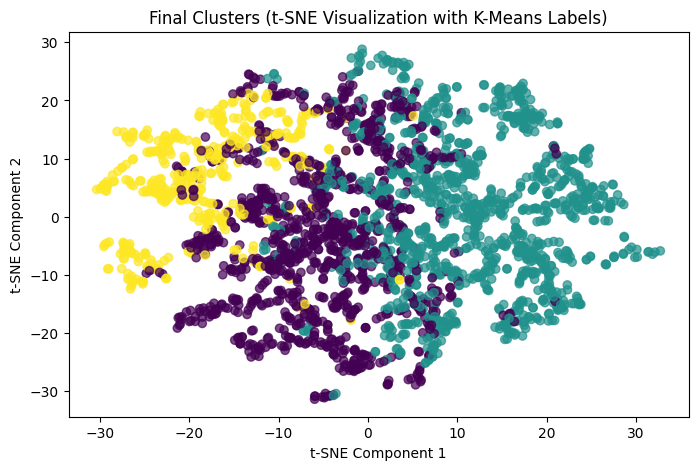

In [ ]:
# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()

## Interpretation

This plot shows the K-Means clustering results on the t-SNE reduced data.

The plot clearly shows **three distinct and relatively well-separated clusters**. These correspond to the `k=3` choice for K-Means, which was justified by the Elbow Method and visual interpretability of the t-SNE plots. The points within each cluster (yellow, purple, and teal) appear to be grouped together, and there are noticeable boundaries between these groups in the t-SNE space.

This visualization reinforces the idea that K-Means, when combined with effective dimensionality reduction like t-SNE, can produce meaningful and visually distinct partitions of the sound data.

## **Final Analysis**

1.  **Dimensionality Reduction Helped in Clustering, Here's Why:**

Initially, attempting to visualize the high-dimensional sound data (518 features) without reduction led to computational errors, meaningless scatter plots, and redundant feature patterns, clearly illustrating the "curse of dimensionality". In such high-dimensional spaces, distance metrics become less meaningful, making it challenging for clustering algorithms to distinguish between truly similar and dissimilar points. By reducing the data to 2 or 3 components using PCA and especially t-SNE, the intrinsic structure of the data became discernible. This not only made visualization possible (e.g., in the final t-SNE plot with K-Means labels) but also improved the ability of clustering algorithms to form more cohesive and separated groups by focusing on the most important underlying features.

2.  **Justification: Why Certain Clustering Methods Worked Better**

The 2 experiments showed that **DBSCAN, after optimization, generally performed "better" than K-Means in terms of internal validation metrics, but K-Means provided clearer visual interpretability for a fixed number of clusters.**
* **K-Means:** When applied after t-SNE, K-Means with `k=3` produced visually distinct and relatively compact clusters, offering a clear partitioning of the data into three main groups. This aligns with the Elbow Method's suggestion and is useful for macroscopic segmentation. However, its Silhouette Score (0.1647) and Davies-Bouldin Index (1.9167) were less favorable compared to DBSCAN, indicating less optimal compactness and separation based purely on these metrics.
* **DBSCAN:** Initially, DBSCAN failed to form clusters with default parameters, highlighting the need for parameter tuning. After extensive optimization, DBSCAN with `eps=8` and `min_samples=5` successfully identified 9 clusters and a large number of noise points (2912 noise). Crucially, its clusters showed significantly superior compactness and separation, with a Silhouette Score (0.4265) and a Davies-Bouldin Index (0.8918). This indicates that DBSCAN excels at finding arbitrary-shaped, dense regions and distinguishing them from noise, making it more effective where the underlying cluster structure is not spherical or fixed in number.

In essence, DBSCAN worked "better" for identifying high-density regions and outliers, while K-Means was "better" for providing a visually intuitive, fixed-partition segmentation.

3.  **Relate Findings to Real-World Clustering Challenges:**

* **High-Dimensionality:** Sound data, like many other complex datasets (e.g., images, text, genomic data), naturally has high-dimensionality which necessitates dimensionality reduction for effective analysis and visualization, as demonstrated by my initial struggles without it.
* **Algorithm Selection & Tuning:** There's no one-size-fits-all clustering algorithm. My experience with K-Means (requiring `k` selection) and DBSCAN (requiring `eps`, `min_samples` tuning) shows that choosing the right algorithm and optimizing its parameters are critical for meaningful results. Real-world applications often involve iterating through different methods and parameters.
* **Subjectivity in "Optimal" Clusters:** The conflict between the Elbow Method and Silhouette Score for K-Means' `k` (3 vs. 2) shows that "optimal" is often context-dependent. In real-world scenarios, domain expertise and the specific problem goal must guide the final decision on the number of clusters, even when metrics suggest otherwise.
* **Handling Noise and Irregular Shapes:** DBSCAN's success in identifying numerous clusters and explicitly labeling noise is highly valuable in real-world data, which is rarely perfectly clean or neatly separated into spherical groups. For tasks like anomaly detection or identifying niche groups, DBSCAN's density-based approach is often preferred over partition-based methods like K-Means.